In [19]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
from numpy import load
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Q2_images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Load Dataset

In [20]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [21]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [22]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

## Forecasting Several Steps Ahead

If we want to predict the next 10 values, instead of just 1, we can modify our previous model to predict the next 10 values. We first need to load the dataset that has sequences with 9 more time steps.

In [23]:
n_steps = 60
series = load('univariate-time-series-multi-step.npy')

X_train, y_train = series[:9000, :n_steps], series[:9000, -1] # -1 references the last column
X_valid, y_valid = series[9000:11000, :n_steps], series[9000:11000, -1]
X_test, y_test = series[11000:, :n_steps], series[11000:, -1]

In [24]:
#RNN Model
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[60, 1]),
    keras.layers.LSTM(16, activation='relu'),
    keras.layers.Dense(10)
])

lstm_model.compile(loss="mse", optimizer="adam")

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 32)            4352      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 10)                170       
                                                                 
Total params: 7,658
Trainable params: 7,658
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = lstm_model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
282/282 [==============================] - 28s 96ms/step - loss: 0.1032 - val_loss: 0.0658
Epoch 2/20
282/282 [==============================] - 27s 94ms/step - loss: 0.0551 - val_loss: 0.0523
Epoch 3/20
282/282 [==============================] - 27s 95ms/step - loss: 0.0448 - val_loss: 0.0435
Epoch 4/20
282/282 [==============================] - 26s 93ms/step - loss: 0.0390 - val_loss: 0.0378
Epoch 5/20
282/282 [==============================] - 27s 94ms/step - loss: 0.0357 - val_loss: 0.0357
Epoch 6/20
282/282 [==============================] - 26s 92ms/step - loss: 0.0340 - val_loss: 0.0335
Epoch 7/20
282/282 [==============================] - 26s 92ms/step - loss: 0.0321 - val_loss: 0.0335
Epoch 8/20
282/282 [==============================] - 26s 92ms/step - loss: 0.0315 - val_loss: 0.0333
Epoch 9/20
282/282 [==============================] - 26s 91ms/step - loss: 0.0311 - val_loss: 0.0326
Epoch 10/20
282/282 [==============================] - 27s 95ms/step - loss: 0.030

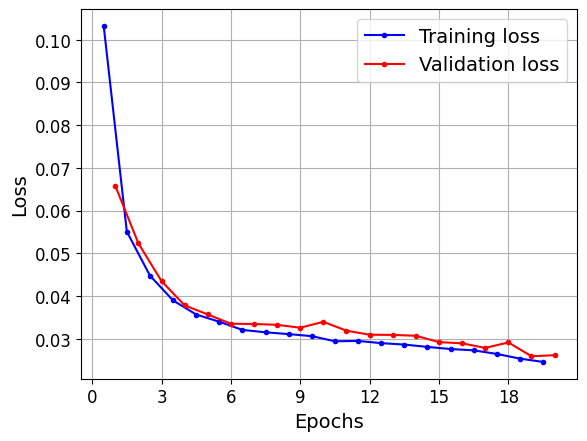

In [26]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

Now let's predict the next 10 values:

In [27]:
series = load('univariate-time-series-multi-step-test.npy')
X_new, Y_new = series[:, :60, :], series[:, -10:, :]
Y_pred = lstm_model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 254ms/step


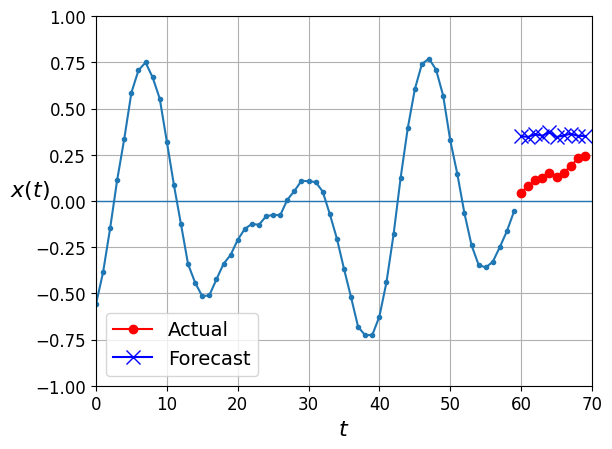

In [28]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [29]:
lstm_model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 15ms/step - loss: 0.0232


0.023240314796566963